# Calculate CESM Indeces

This file :
- calculates all the indeces for all months for all cesmFullForcingFiles 
- applies a time average to give a warm-season average for each index
- finds when events are compounding to be fire pos or fire neg in south-east Australia

Indices are defined in utilts/_index.py
Experiment set is defined in utils/_model.py



In [1]:
#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp
import utils.compound as compound


In [2]:
import xarray
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

# 1. Calculate CESM Indeces

Data for climatology

For each experiment in Full Forcings, calculate all the indeces

# 2. Average over the time period of interest to give an annual index

This grabs the monthly CESM indeces, and calculates the averages for the time periods of interest (aka the warm season), as set in the _indexDefitionions file

Theres a few examples of output at the bottom to sanity check this is meaningful

The indeces for each month have already been calculated. So loading up the saved versions, and putting them into a single xarray.

In [ ]:
timePIndeces=list()

for experiment in _model.cesmAll:
    print(experiment)
    indecesDs = xarray.open_dataset('results/cesmMonthlyIndeces/' + experiment + '.nc')

    timePIndeces.append(tp.averageForTimePeriod(indecesDs))


results=xarray.concat(timePIndeces, 'experiment')

In [ ]:
results['experiment']=_model.cesmAll

results=results.assign_attrs({**indecesDs.attrs})


Save the result for use later

In [ ]:
results.to_netcdf('results/cesmTradIndeces.nc')

# 2.a Some sanity checks to see if it looks ok:


In [6]:
results=xarray.open_dataset('results/cesmTradIndeces.nc')

In [7]:
results

<xarray.Dataset>
Dimensions:                 (experiment: 18, year: 1250)
Coordinates:
  * year                    (year) int64 850 851 852 853 ... 2096 2097 2098 2099
  * experiment              (experiment) object 'LME.002' 'LME.003' ... '013'
Data variables:
    backgroundSstNoDetrend  (experiment, year) float64 ...
    nino4                   (experiment, year) float64 ...
    westIO                  (experiment, year) float64 ...
    eastIO                  (experiment, year) float64 ...
    nino4NoDetrend          (experiment, year) float64 ...
    samWinter               (experiment, year) float64 ...
    samSummer               (experiment, year) float64 ...
    nino34NoDetrend         (experiment, year) float64 ...
    nino34                  (experiment, year) float64 ...
    dmi                     (experiment, year) float64 ...
    westIONoDetrend         (experiment, year) float64 ...
    eastIONoDetrend         (experiment, year) float64 ...

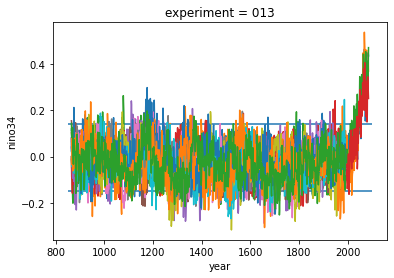

In [8]:
toPlot=results['nino34'].rolling(year=30,center=True).mean('year')


[
    toPlot.sel(experiment=iExp).plot()
        for iExp in _model.cesmNoRepeats
]

mean=toPlot.sel(experiment='0850cntl.001').mean()
std=toPlot.sel(experiment='0850cntl.001').std()


plt.hlines([
    mean+1.96*std,mean-1.96*std
],850,2100)

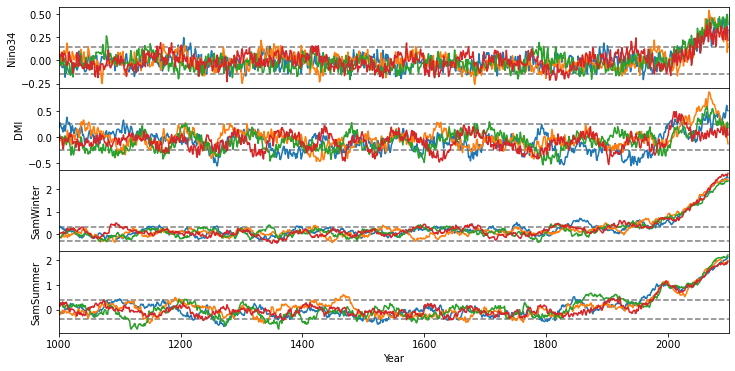

In [9]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

indexToPlot = ['nino34', 'dmi', 'samWinter', 'samSummer']
labels = ['Nino34', 'DMI', 'SamWinter', 'SamSummer']
colors = ['peru', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple']
lims = [(-4,4), [-4,4], [-4,4], [-4,4]]

fig = plt.figure(figsize=(12,6))

for i in range(4):

    #create a subplot (row, column, size)
    ax=fig.add_subplot(4,1,i+1)

    # plot the actual data
    plotData=results[indexToPlot[i]].sel(experiment=_model.cesmRcp85).rolling(year=30, min_periods=15, center=True).mean('year')

    #blue line for multi-experiment mean, and light blue shading between min and max
    for iExperiment in plotData.experiment.values:
        plt.plot(
            plotData.year, 
            #plotData.mean('experiment').values,
            plotData.sel(experiment=iExperiment).values, 
            label=iExperiment, 
            #color=colors[i]
        ) 

    plt.ylabel(labels[i])
    #plt.legend(loc='upper left')
    
    
    mean=results[indexToPlot[i]].sel(experiment=_model.cesmCntl).rolling(year=30, min_periods=15, center=True).mean('year').mean().values
    std=results[indexToPlot[i]].sel(experiment=_model.cesmCntl).rolling(year=30, min_periods=15, center=True).mean('year').std().values
    
    plt.hlines([mean+1.96*std,mean-1.96*std],1000,2100, linestyles='dashed', color='grey')
   
    
    plt.xlim([1000,2100])
    plt.xlabel('')
    ax.xaxis.set_visible(False)

    
plt.subplots_adjust(hspace=0)
plt.xlabel('Year')
ax.xaxis.set_visible(True)

plt.savefig('figures/cesmIndicesMeanStateTrends.pdf')

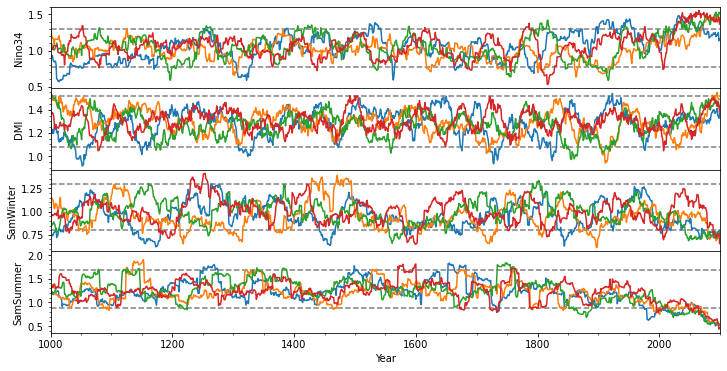

In [10]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

indexToPlot = ['nino34', 'dmi', 'samWinter', 'samSummer']
labels = ['Nino34', 'DMI', 'SamWinter', 'SamSummer']
colors = ['peru', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple']
lims = [(-4,4), [-4,4], [-4,4], [-4,4]]

fig = plt.figure(figsize=(12,6))

for i in range(4):

    #create a subplot (row, column, size)
    ax=fig.add_subplot(4,1,i+1)

    # plot the actual data
    plotData=results[indexToPlot[i]].sel(experiment=_model.cesmRcp85).rolling(year=30, min_periods=15, center=True).std('year')

    #blue line for multi-experiment mean, and light blue shading between min and max
    for iExperiment in plotData.experiment.values:
        plt.plot(
            plotData.year, 
            #plotData.mean('experiment').values,
            plotData.sel(experiment=iExperiment).values, 
            label=iExperiment, 
            #color=colors[i]
        ) 

    plt.ylabel(labels[i])
    #plt.legend(loc='upper left')
    
    
    mean=results[indexToPlot[i]].sel(experiment=_model.cesmCntl).rolling(year=30, min_periods=15, center=True).std('year').mean().values
    std=results[indexToPlot[i]].sel(experiment=_model.cesmCntl).rolling(year=30, min_periods=15, center=True).std('year').std().values
    
    plt.hlines([mean+1.96*std,mean-1.96*std],1000,2100, linestyles='dashed', color='grey')
   
    
    plt.xlim([1000,2100])
    #plt.ylim([-5,7])
    plt.minorticks_on()
    plt.xlabel('')
    ax.xaxis.set_visible(False)

    
plt.subplots_adjust(hspace=0)
plt.xlabel('Year')
ax.xaxis.set_visible(True)



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


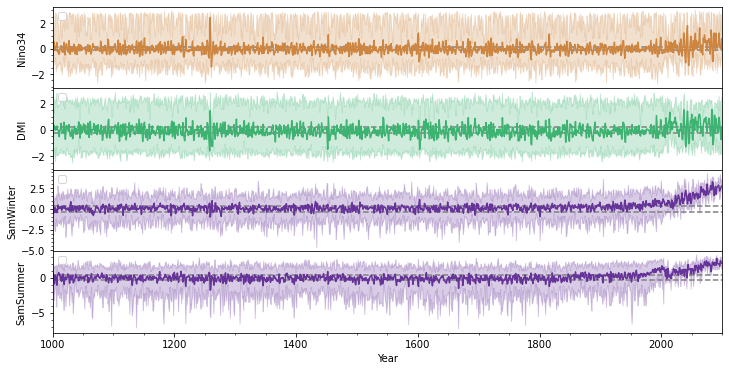

In [11]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

indexToPlot = ['nino34', 'dmi', 'samWinter', 'samSummer']
labels = ['Nino34', 'DMI', 'SamWinter', 'SamSummer']
colors = ['peru', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple']

fig = plt.figure(figsize=(12,6))

for i in range(4):

    #create a subplot (row, column, size)
    ax=fig.add_subplot(4,1,i+1)

    # plot the actual data
    plotData=results[indexToPlot[i]]#.sel(experiment=_model.cesmNoRepeats).rolling(year=30, min_periods=15, center=True).mean('year')

    #blue line for multi-experiment mean, and light blue shading between min and max
    plt.plot(
        plotData.year, 
        plotData.mean('experiment').values,
        #label=iExperiment, 
        color=colors[i]
    ) 

    plt.ylabel(labels[i])
    plt.legend(loc='upper left')
    
    #obsXr[indexToPlot[i]].plot(alpha=0.5, linestyle='-')
    
    plt.fill_between(
        plotData.year, plotData.min('experiment').values, plotData.max('experiment').values, 
                     color=colors[i], alpha=0.25
    )
    
    mean=results[indexToPlot[i]].sel(experiment=_model.cesmCntl).rolling(year=30, min_periods=15, center=True).mean('year').mean().values
    std=results[indexToPlot[i]].sel(experiment=_model.cesmCntl).rolling(year=30, min_periods=15, center=True).mean('year').std().values
    
    plt.hlines([mean+1.96*std,mean-1.96*std],1000,2100, linestyles='dashed', color='grey')
    
    plt.xlim([1000,2100])
    #plt.ylim([-5,7])
    plt.minorticks_on()
    plt.xlabel('')
    ax.xaxis.set_visible(False)

    
plt.subplots_adjust(hspace=0)
plt.xlabel('Year')
ax.xaxis.set_visible(True)



# 3. Calculate Compound Years for CESM

In [12]:
# Here is the data
indecesDs = xarray.open_dataset('results/cesmTradIndeces.nc')

indecesDs.experiment.values

array(['LME.002', 'LME.003', 'LME.008', 'LME.009', '0850cntl.001', '001',
       '002', '003', '004', '005', '006', '007', '008', '009', '010',
       '011', '012', '013'], dtype=object)

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

Using the control run as climatology

In [13]:
# This should calculate stds for all experiments and all indeces
stdDa = indecesDs.sel(experiment=_model.cesmCntl).std(dim='year')

In [14]:
# define some criteria that we want to use to identifiy it thats an event. Its the same for evey experiment this time
criteriaDa= xarray.merge(
    (stdDa[['nino34','dmi', 'eastIO']], stdDa[['samWinter','samSummer']]/2)
)

# criteria is the same for every experiment becuase it comes from the climatology
criteriaDa = xarray.concat([
    criteriaDa for i in range(0,len(_model.cesmAll))
], 'experiment')
criteriaDa['experiment'] = _model.cesmAll

criteriaDa

<xarray.Dataset>
Dimensions:     (experiment: 18)
Coordinates:
  * experiment  (experiment) <U12 'LME.002' 'LME.003' 'LME.008' ... '012' '013'
Data variables:
    nino34      (experiment) float64 1.05 1.05 1.05 1.05 ... 1.05 1.05 1.05 1.05
    dmi         (experiment) float64 1.309 1.309 1.309 ... 1.309 1.309 1.309
    eastIO      (experiment) float64 0.9866 0.9866 0.9866 ... 0.9866 0.9866
    samWinter   (experiment) float64 0.5359 0.5359 0.5359 ... 0.5359 0.5359
    samSummer   (experiment) float64 0.6559 0.6559 0.6559 ... 0.6559 0.6559

<b>Calculate the compounding years and plot an example</b>

In [15]:
firePos, fireNeg = compound.applyCriteria(indecesDs, criteriaDa)

firePos=compound.compound(firePos)

fireNeg=compound.compound(fireNeg)

firePos: 
['nino34', 'samWinter', 'dmi']
fireNeg: 
['eastIO', 'samSummer']
nino34EastioSamwinter
nino34EastioSamsummer
nino34DmiSamwinter
nino34DmiSamsummer
nino34EastioSamwinter
nino34EastioSamsummer
nino34DmiSamwinter
nino34DmiSamsummer


In [16]:
firePos.to_netcdf('results/cesmFirePos.nc')

fireNeg.to_netcdf('results/cesmFireNeg.nc')

In [17]:
#check that years where this is no-data is a nan (rather than 0)
firePos.sel(experiment='001')

<xarray.Dataset>
Dimensions:                (compound: 9, year: 1250)
Coordinates:
  * year                   (year) int64 850 851 852 853 ... 2096 2097 2098 2099
    experiment             <U3 '001'
  * compound               (compound) <U11 'nEvents' 'all3' ... 'anyCompound'
Data variables:
    nino34EastioSamwinter  (compound, year) float64 1.0 1.0 1.0 ... nan nan nan
    nino34EastioSamsummer  (compound, year) float64 2.0 2.0 1.0 ... nan nan nan
    nino34DmiSamwinter     (compound, year) float64 1.0 1.0 1.0 ... nan nan nan
    nino34DmiSamsummer     (compound, year) float64 2.0 2.0 1.0 ... nan nan nan
Attributes:
    indexNames:  ['nino34', 'eastIO', 'samWinter']
    indeces:     ['enso', 'iod', 'sam']
    pairs:       ['enso+iod', 'enso+sam', 'iod+sam']
    others:      ['all3', 'anyCompound', 'nEvents']

Text(0.5, 1.0, 'LME.002: Pairs and all-three compounds for individal years')

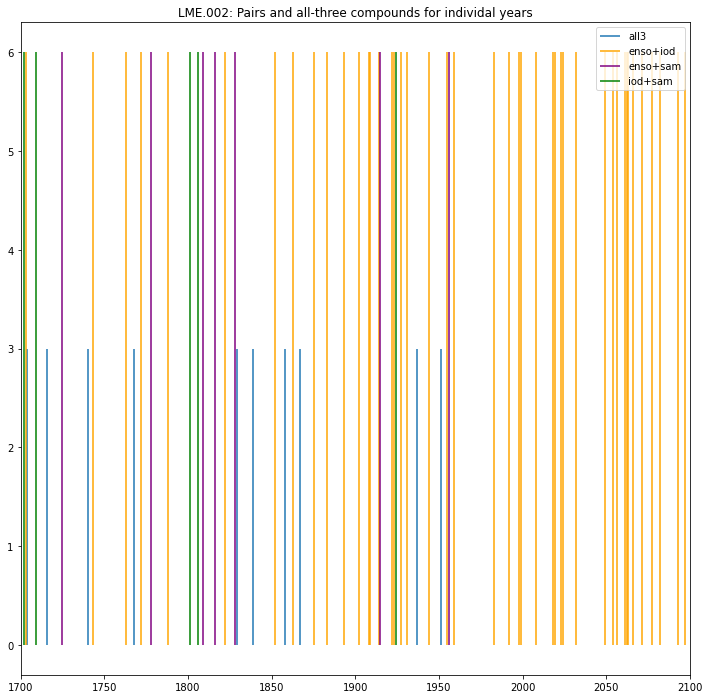

In [18]:
#plot an example
expToPlot = 'LME.002'

toPlot=3*firePos.nino34DmiSamsummer.sel(experiment=expToPlot).to_dataset('compound')

plt.figure(figsize=(12,12))

plt.vlines(
    x=toPlot.year, 
    ymin=0,
    ymax=toPlot.all3,
    label='all3'
)

colors=['orange', 'purple', 'green']
iCol = 0

for iPair in firePos.attrs['pairs']:
    plt.vlines(
        x=toPlot.year, 
        ymin=0,
        ymax=2*toPlot[iPair],
        color=colors[iCol],
        label=iPair
    )
    iCol+=1
plt.legend()
plt.xlim(1700,2100)
plt.title(expToPlot+': Pairs and all-three compounds for individal years')